In [5]:
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from xgboost import XGBRegressor
from sklearn.svm import SVR

In [6]:
def xgb_model(epochs, objective, booster, max_depth):
    model = XGBRegressor(n_estimators = epochs,
                         max_depth = max_depth,
                         objective = objective,
                         tree_method = 'gpu_hist',
                         booster = booster,
                         verbosity = 1)
    return model


In [7]:
def get_data():
    df = pd.read_excel('~/git/water/Cost-B.xlsx')
    df2 = df.rename({df.columns[0]: 'dirt', df.columns[-1]: 'cost'}, axis=1)
    df2.pop(df.columns[1])
    df = df2.copy()
    data_cost = df.pop('cost')
    label = df.pop('dirt')
    
    # add time msg
    index = list(range(len(df)))
    df['time'] = pd.DataFrame(index)
    
    return df, label

In [10]:
def lr_curve(results, ylabel, title):
    keys = list(results.keys())
    item = list(results[keys[0]].keys())[0]
    epochs = len(results[keys[0]][item])
    x_axis = range(0, epochs)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.plot(x_axis, results["validation_0"][item], label="Train")
    ax.plot(x_axis, results["validation_1"][item], label="Test")
    ax.legend()
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


In [18]:
def eva_metric(y_true, y_pred):
    dic = {'mse':mean_squared_error,
       'mae': mean_absolute_error,
       'r2_score': r2_score}
    
    r2 = []
    for i in dic.keys():
        score = dic[i](y_true, y_pred)
#         print(i, score)
        if i == 'r2_score':
            r2.append(score)
    return r2


In [19]:
# X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.33, random_state=42)


def xgb_grid_test(df, label):
    
    X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.33, random_state=42)
    
    plot = False
    dic = {'obj':['reg:squarederror', 'reg:linear'],
           'booster':['gblinear', 'gbtree', 'dart'],
           'max_depth':[4, 8, 12]}

    best_lis = []
    record_dic = {'obj':[],
                  'booster':[],
                  'max_depth':[],
                  'score':[] }
    max_score = 0
    for a in dic['obj']:
        for b in dic['booster']:
            for c in dic['max_depth']:
                print(a, b, 'max_depth =', c)

                # model training 
                model = xgb_model(200, a, b, c)
                model.fit(X_train, y_train,
                        eval_set=[(X_train, y_train), (X_test, y_test)],
                        eval_metric='mae', verbose = False)

                # model predict and evaulate.
                y_pred = model.predict(X_test)
                y_true = y_test
                r2 = eva_metric(y_true, y_pred)

                record_dic['obj'].append(a)
                record_dic['booster'].append(b)
                record_dic['max_depth'].append(c)
                record_dic['score'].append(r2[0])

                # record best score
                if r2[0] > max_score:
                    max_score = r2[0]
                    best_lis.append(a+' '+b+' '+'max_depth ='+str(c))

                results = model.evals_result()

                # plot lr curve for mae
                if plot:
                    lr_curve(results, 'xgb linear', 'learning curve of gblinear')
    print(best_lis, max_score)
    return record_dic
'''
best 
['reg:squarederror gblinear max_depth =4'] 0.9945255065268811
'''

"\nbest \n['reg:squarederror gblinear max_depth =4'] 0.9945255065268811\n"

In [20]:
def svm_grid_test(df, label):
    X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.33, random_state=42)

    svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
    svr_lin = SVR(kernel='linear', C=100, gamma='auto')
    svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, 
                   coef0=1, verbose = True)            # poly 跑很久 沒再動
    lis = []
    dic = {'svr_rbf':svr_rbf,
           'svr_lin':svr_lin} 
    for i in list(dic.keys()):
        print(i)
        model = dic[i]
        y_train = np.array(y_train)
#         y_train = np.squeeze(y_train, axis = -1)
        
        print('train svm with '+i)
        model.fit(X_train, np.array(y_train))
        
        y_true = y_test
        y_pred = model.predict(X_test)
        r2 = eva_metric(y_true, y_pred)
#         print(i, r2)
        lis.append([i, r2[0]])
    return lis

# EDA

In [14]:
df, label = get_data()
print(label.head())
df.head()

0    70.0
1    70.0
2    70.0
3    71.0
4    71.0
Name: dirt, dtype: float64


,C,D,time
0,17.000000,118.000000,0
1,114.680482,171.433735,1
2,287.000000,208.000000,2
3,17.000000,118.000000,3
4,123.428571,184.785714,4


## 待處理

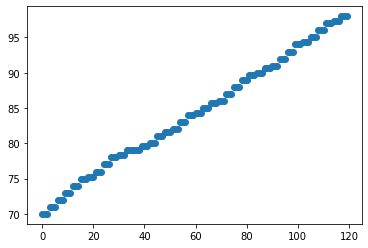

In [15]:
# 資料可能是連續的 要調整
x_axis = np.array(range(len(label)))
plt.scatter(x_axis, label, marker='o')

## Naive-model training

In [57]:
df, label = get_data()

# test on xgb
record_dic = xgb_grid_test(df, label)
# test on svm
svm_lis = svm_grid_test(df, label)

# record svm into dic
record_dic['svr_rbf'] = [np.nan]*len(record_dic['score'])
record_dic['svr_rbf'] =  svm_lis[0]+[np.nan]*(len(record_dic['score'])-len(svm_lis[0]))
record_dic['svr_linear'] = [np.nan]*len(record_dic['score'])
record_dic['svr_linear'] = svm_lis[1]+[np.nan]*(len(record_dic['score'])-len(svm_lis[1]))

# save to csv
record = pd.DataFrame(record_dic)
record.to_csv('./naive_training.csv')
record

svr_rbf
train svm with svr_rbf
svr_lin
train svm with svr_lin


,obj,booster,max_depth,score,svr_rbf,svr_linear
0,reg:squarederror,gblinear,4,0.821026,svr_rbf,svr_lin
1,reg:squarederror,gblinear,8,0.821026,0.234016,0.990287
2,reg:squarederror,gblinear,12,0.821026,NaN,NaN
3,reg:squarederror,gbtree,4,0.994680,NaN,NaN
4,reg:squarederror,gbtree,8,0.994514,NaN,NaN
5,reg:squarederror,gbtree,12,0.994526,NaN,NaN
6,reg:squarederror,dart,4,0.994681,NaN,NaN
7,reg:squarederror,dart,8,0.994538,NaN,NaN
8,reg:squarederror,dart,12,0.994526,NaN,NaN
9,reg:linear,gblinear,4,0.821026,NaN,NaN


## Sensor sensitivity disturb 

In [58]:
def sig_disturb(data2func, percent):
    percent = percent
    y = data2func.copy()
    np.random.seed(1)

    nums = int(len(y)/100*percent)
    if nums == 0:
        nums = 1
    rand = np.random.choice(range(len(y)), nums, replace=False)
    noise = []
    for i in y[rand]:
        a = np.random.normal(loc=i, scale=y.std())
        noise.append(a)
    noise = np.array(noise)
    noise *= 0.01
    y[rand] += noise
    return y, rand

8.017064433372823
8.123171899843314


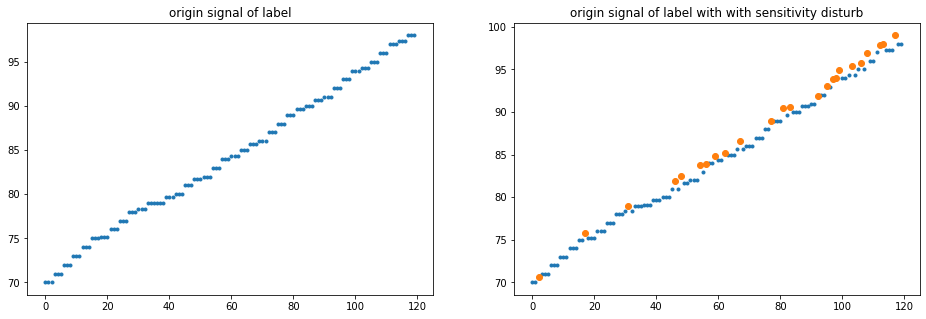

In [59]:
# 雜訊
df , label = get_data()
# add noise on dirt 

print(label.std())
x_axis = np.array(range(len(label)))


# add noise
noise_label, rand= sig_disturb(label, 20)
print(noise_label.std())

# plot
fig=plt.figure(figsize = (16, 5))

fig_place = [1,2]

subplot1 = fig.add_subplot(fig_place[0], fig_place[1], 1)
plt.scatter(x_axis, label, marker='.')
plt.title("origin signal of label", y=1)

subplot2 = fig.add_subplot(fig_place[0], fig_place[1], 2)
plt.title("origin signal of label with with sensitivity disturb")
plt.scatter(x_axis, noise_label, marker='.')
plt.scatter(x_axis[rand], noise_label[rand], marker='o')

In [61]:
df, label = get_data()
noise_label, rand= sig_disturb(label, 20)

# sig. disturb 
label = noise_label

# test on xgb
record_dic = xgb_grid_test(df, label)
# test on svm
svm_lis = svm_grid_test(df, label)

# record svm into dic
record_dic['svr_rbf'] = [np.nan]*len(record_dic['score'])
record_dic['svr_rbf'] =  svm_lis[0]+[np.nan]*(len(record_dic['score'])-len(svm_lis[0]))
record_dic['svr_linear'] = [np.nan]*len(record_dic['score'])
record_dic['svr_linear'] = svm_lis[1]+[np.nan]*(len(record_dic['score'])-len(svm_lis[1]))

# save to csv
record = pd.DataFrame(record_dic)
record.to_csv('./disturb_training.csv')
record

reg:squarederror gblinear max_depth = 4
reg:squarederror gblinear max_depth = 8
reg:squarederror gblinear max_depth = 12
reg:squarederror gbtree max_depth = 4
reg:squarederror gbtree max_depth = 8
reg:squarederror gbtree max_depth = 12
reg:squarederror dart max_depth = 4
reg:squarederror dart max_depth = 8
reg:squarederror dart max_depth = 12
reg:linear gblinear max_depth = 4
[04:02:43] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
reg:linear gblinear max_depth = 8
[04:02:43] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
reg:linear gblinear max_depth = 12
[04:02:43] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
reg:linear gbtree max_depth = 4
[04:02:43] WARNING: /opt/con

,obj,booster,max_depth,score,svr_rbf,svr_linear
0,reg:squarederror,gblinear,4,0.815162,svr_rbf,svr_lin
1,reg:squarederror,gblinear,8,0.815162,0.225359,0.991983
2,reg:squarederror,gblinear,12,0.815162,NaN,NaN
3,reg:squarederror,gbtree,4,0.993090,NaN,NaN
4,reg:squarederror,gbtree,8,0.993923,NaN,NaN
5,reg:squarederror,gbtree,12,0.993942,NaN,NaN
6,reg:squarederror,dart,4,0.993098,NaN,NaN
7,reg:squarederror,dart,8,0.993922,NaN,NaN
8,reg:squarederror,dart,12,0.993938,NaN,NaN
9,reg:linear,gblinear,4,0.815162,NaN,NaN


## Transmission noise
突波雜訊的控制與模型訓練。突波會顯著的對模型產生影響，所以需要先行濾除。

In [62]:
def sig_transmittion_noise(data2func, percent):
    percent = percent
    y = data2func.copy()
    np.random.seed(1)

    nums = int(len(y)/100*percent)
    if nums == 0:
        nums = 1
    rand = np.random.choice(range(len(y)), nums, replace=False)
#     noise = np.ones(nums)
#     noise*=1000
    y[rand] = 1000
    
    return y, rand


8.017064433372823
368.26362915703874


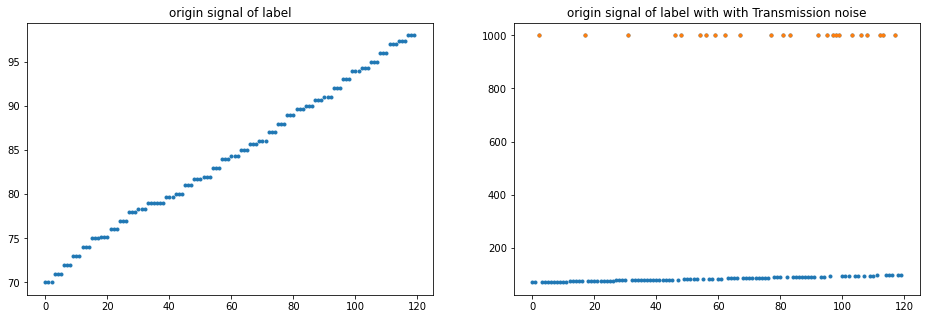

In [118]:
# 雜訊
df_noise, label = get_data()
# add noise on dirt 

print(label.std())
x_axis = np.array(range(len(label)))


# add noise
noise_label, rand= sig_transmittion_noise(label, 20)
print(noise_label.std())

# plot
fig=plt.figure(figsize = (16, 5))

fig_place = [1,2]

subplot1 = fig.add_subplot(fig_place[0], fig_place[1], 1)
plt.scatter(x_axis, label, marker='.')
plt.title("origin signal of label", y=1)

subplot2 = fig.add_subplot(fig_place[0], fig_place[1], 2)
plt.title("origin signal of label with with Transmission noise")
plt.scatter(x_axis, noise_label, marker='.')
plt.scatter(x_axis[rand], noise_label[rand], marker='.')

### Transmission noise-去除雜訊後訓練

In [68]:
# 在訓練資料中會遇到雜訊突波 但在測試資料集上不應該有(因為那是我們的預測目標) 
# 在訓練集上filter離群值後訓練 預測就不會受離群值影響
df, label = get_data()
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.33, random_state=42)

train = pd.concat([X_train, y_train], axis = 1).reset_index(drop=True)

noise_label, _= sig_transmittion_noise(train['dirt'], 30)
train.loc[_, 'dirt'] = 1000
arr = train['dirt'].values
thres = arr.mean() + arr.std()
outlier_filter = np.array(arr<thres)

X_clean = train[outlier_filter]
y_clean = X_clean.pop('dirt')

In [69]:
df = X_clean
label = y_clean

# test on xgb
record_dic = xgb_grid_test(df, label)
# test on svm
svm_lis = svm_grid_test(df, label)

# record svm into dic
record_dic['svr_rbf'] = [np.nan]*len(record_dic['score'])
record_dic['svr_rbf'] =  svm_lis[0]+[np.nan]*(len(record_dic['score'])-len(svm_lis[0]))
record_dic['svr_linear'] = [np.nan]*len(record_dic['score'])
record_dic['svr_linear'] = svm_lis[1]+[np.nan]*(len(record_dic['score'])-len(svm_lis[1]))

# save to csv
record = pd.DataFrame(record_dic)
record.to_csv('./noise_training.csv')
record

reg:squarederror gblinear max_depth = 4
reg:squarederror gblinear max_depth = 8
reg:squarederror gblinear max_depth = 12
reg:squarederror gbtree max_depth = 4
reg:squarederror gbtree max_depth = 8
reg:squarederror gbtree max_depth = 12
reg:squarederror dart max_depth = 4
reg:squarederror dart max_depth = 8
reg:squarederror dart max_depth = 12
reg:linear gblinear max_depth = 4
[04:06:54] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
reg:linear gblinear max_depth = 8
[04:06:54] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
reg:linear gblinear max_depth = 12
[04:06:54] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
reg:linear gbtree max_depth = 4
[04:06:54] WARNING: /opt/con

,obj,booster,max_depth,score,svr_rbf,svr_linear
0,reg:squarederror,gblinear,4,0.743065,svr_rbf,svr_lin
1,reg:squarederror,gblinear,8,0.743065,0.0486364,0.987082
2,reg:squarederror,gblinear,12,0.743065,NaN,NaN
3,reg:squarederror,gbtree,4,0.992041,NaN,NaN
4,reg:squarederror,gbtree,8,0.991955,NaN,NaN
5,reg:squarederror,gbtree,12,0.991946,NaN,NaN
6,reg:squarederror,dart,4,0.992051,NaN,NaN
7,reg:squarederror,dart,8,0.991954,NaN,NaN
8,reg:squarederror,dart,12,0.991947,NaN,NaN
9,reg:linear,gblinear,4,0.743065,NaN,NaN


### Transmission noise-保留雜訊訓練

In [73]:
# 在訓練資料中會遇到雜訊突波 但在測試資料集上不應該有(因為那是我們的預測目標) 
# 在訓練集上filter離群值後訓練 預測就不會受離群值影響
df, label = get_data()
X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.33, random_state=42)

train = pd.concat([X_train, y_train], axis = 1).reset_index(drop=True)

noise_label, _= sig_transmittion_noise(train['dirt'], 30)
train.loc[_, 'dirt'] = 1000

y_train = train.pop('dirt')
X_train = train
# 進行測試
df = X_train
label = y_train

# test on xgb
record_dic = xgb_grid_test(df, label)
# test on svm
svm_lis = svm_grid_test(df, label)

# record svm into dic
record_dic['svr_rbf'] = [np.nan]*len(record_dic['score'])
record_dic['svr_rbf'] =  svm_lis[0]+[np.nan]*(len(record_dic['score'])-len(svm_lis[0]))
record_dic['svr_linear'] = [np.nan]*len(record_dic['score'])
record_dic['svr_linear'] = svm_lis[1]+[np.nan]*(len(record_dic['score'])-len(svm_lis[1]))

# save to csv
record = pd.DataFrame(record_dic)
record.to_csv('./noise_with_outlier_training.csv')
record

reg:squarederror gblinear max_depth = 4
reg:squarederror gblinear max_depth = 8
reg:squarederror gblinear max_depth = 12
reg:squarederror gbtree max_depth = 4
reg:squarederror gbtree max_depth = 8
reg:squarederror gbtree max_depth = 12
reg:squarederror dart max_depth = 4
reg:squarederror dart max_depth = 8
reg:squarederror dart max_depth = 12
reg:linear gblinear max_depth = 4
[04:12:20] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
reg:linear gblinear max_depth = 8
[04:12:20] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
reg:linear gblinear max_depth = 12
[04:12:20] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
reg:linear gbtree max_depth = 4
[04:12:20] WARNING: /opt/con

,obj,booster,max_depth,score,svr_rbf,svr_linear
0,reg:squarederror,gblinear,4,-0.040531,svr_rbf,svr_lin
1,reg:squarederror,gblinear,8,-0.040531,-0.502532,-0.583654
2,reg:squarederror,gblinear,12,-0.040531,NaN,NaN
3,reg:squarederror,gbtree,4,-0.721973,NaN,NaN
4,reg:squarederror,gbtree,8,-0.790180,NaN,NaN
5,reg:squarederror,gbtree,12,-0.783635,NaN,NaN
6,reg:squarederror,dart,4,-0.721973,NaN,NaN
7,reg:squarederror,dart,8,-0.779762,NaN,NaN
8,reg:squarederror,dart,12,-0.773469,NaN,NaN
9,reg:linear,gblinear,4,-0.040531,NaN,NaN


## Delay feedback
1. 選定一個欄位 隨機shift一個連續時間區域的資料

In [ ]:
# Delay feedback
df, label = get_data()

np.random.seed(1)
num = 1
block_width = 7
rand = np.random.choice(range(len(label)-block_width), num, replace=False)[0]
# delay = np.array(range(rand[0],rand[0]+block_width))
# label[delay]

delay_label = label.copy()
for i in range(len(delay_label)-block_width-1, rand-1, -1):
#     print(i)
    delay_label[i + block_width] = delay_label[i]
    delay_label[i] = 0

delay_label[92:]

# plot
fig=plt.figure(figsize = (16, 5))

fig_place = [1,2]

x_axis = np.array(range(len(label)))

subplot1 = fig.add_subplot(fig_place[0], fig_place[1], 1)
plt.scatter(x_axis, label, marker='.')
plt.scatter(x_axis[rand : rand + block_width], delay_label[rand : rand + block_width], marker='o', c = 'w')
plt.title("origin signal of label", y=1)

subplot2 = fig.add_subplot(fig_place[0], fig_place[1], 2)
plt.title("origin signal of label with with delay feedback")
plt.scatter(x_axis, delay_label, marker='.')
plt.scatter(x_axis[rand : rand + block_width], delay_label[rand : rand + block_width], marker='o', c = 'w')

### delay並訓練

In [22]:
# sig. delay
label = label

# test on xgb
record_dic = xgb_grid_test(df, label)
# test on svm
svm_lis = svm_grid_test(df, label)

# record svm into dic
record_dic['svr_rbf'] = [np.nan]*len(record_dic['score'])
record_dic['svr_rbf'] =  svm_lis[0]+[np.nan]*(len(record_dic['score'])-len(svm_lis[0]))
record_dic['svr_linear'] = [np.nan]*len(record_dic['score'])
record_dic['svr_linear'] = svm_lis[1]+[np.nan]*(len(record_dic['score'])-len(svm_lis[1]))

# save to csv
record = pd.DataFrame(record_dic)
record.to_csv('./delay_training.csv')
record

reg:squarederror gblinear max_depth = 4
reg:squarederror gblinear max_depth = 8
reg:squarederror gblinear max_depth = 12
reg:squarederror gbtree max_depth = 4
reg:squarederror gbtree max_depth = 8
reg:squarederror gbtree max_depth = 12
reg:squarederror dart max_depth = 4
reg:squarederror dart max_depth = 8
reg:squarederror dart max_depth = 12
reg:linear gblinear max_depth = 4
[05:15:01] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
reg:linear gblinear max_depth = 8
[05:15:01] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
reg:linear gblinear max_depth = 12
[05:15:01] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
reg:linear gbtree max_depth = 4
[05:15:01] WARNING: /opt/con

,obj,booster,max_depth,score,svr_rbf,svr_linear
0,reg:squarederror,gblinear,4,0.821026,svr_rbf,svr_lin
1,reg:squarederror,gblinear,8,0.821026,0.234016,0.990287
2,reg:squarederror,gblinear,12,0.821026,NaN,NaN
3,reg:squarederror,gbtree,4,0.994680,NaN,NaN
4,reg:squarederror,gbtree,8,0.994514,NaN,NaN
5,reg:squarederror,gbtree,12,0.994526,NaN,NaN
6,reg:squarederror,dart,4,0.994681,NaN,NaN
7,reg:squarederror,dart,8,0.994538,NaN,NaN
8,reg:squarederror,dart,12,0.994526,NaN,NaN
9,reg:linear,gblinear,4,0.821026,NaN,NaN


## 多重丟失
1. 不同程度的丟失測試

In [31]:
def sig_drop(data2func, percent):
    
    y = data2func.copy()
    x_axis = np.array(range(len(label)))
    percent = percent
    np.random.seed(1)
    nums = int(len(y)/100*percent)
    if nums == 0:
        nums = 1
    print(nums)

    # drop element
    rand = np.random.choice(range(len(y)), nums, replace=False)
    drop_label = y.copy()
    drop_label[rand] = 0 

    return drop_label, rand


36


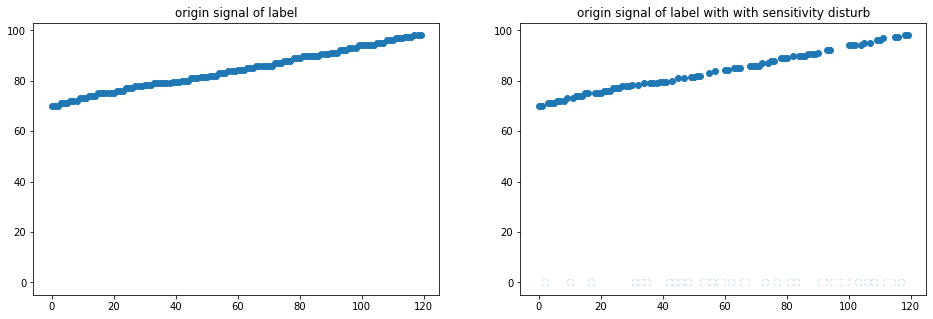

In [32]:
def plt_drop(data2func, percent):
    
    y = data2func.copy()
    x_axis = np.array(range(len(label)))
    drop_label, rand = sig_drop(y, percent)
    # plot
    fig=plt.figure(figsize = (16, 5))

    fig_place = [1,2]

    subplot1 = fig.add_subplot(fig_place[0], fig_place[1], 1)
    plt.scatter(x_axis, y, marker='o')
    plt.scatter(x_axis[rand], drop_label[rand], marker='o', c = 'w')
    plt.title("origin signal of label", y=1)

    subplot2 = fig.add_subplot(fig_place[0], fig_place[1], 2)
    plt.title("origin signal of label with with sensitivity disturb")
    plt.scatter(x_axis, drop_label, marker='o')
    plt.scatter(x_axis[rand], drop_label[rand], marker='o', c = 'w')
df, label = get_data()
plt_drop(label, 30)

### drop training- 丟失並訓練

In [38]:
# 不做處理
df, label = get_data()

drop_label, _ = sig_drop(label, 10)

label = drop_label
print(len(label))
print(len(df))
test on xgb
record_dic = xgb_grid_test(df, label)
# test on svm
svm_lis = svm_grid_test(df, label)

# record svm into dic
record_dic['svr_rbf'] = [np.nan]*len(record_dic['score'])
record_dic['svr_rbf'] =  svm_lis[0]+[np.nan]*(len(record_dic['score'])-len(svm_lis[0]))
record_dic['svr_linear'] = [np.nan]*len(record_dic['score'])
record_dic['svr_linear'] = svm_lis[1]+[np.nan]*(len(record_dic['score'])-len(svm_lis[1]))

# save to csv
record = pd.DataFrame(record_dic)
record.to_csv('./drop10_training.csv')
record

12
120
120


### drop training with solution- 丟失並搭配處理方法後訓練

In [45]:
# drop na
df, label = get_data()


X_train, X_test, y_train, y_test = train_test_split(df, label, test_size=0.1, random_state=42)

train = pd.concat([X_train, y_train], axis = 1).reset_index(drop=True)

drop_label, _ = sig_drop(train.loc[:, 'dirt'], 10)
train.loc[:, 'dirt'] = drop_label
print(len(train))

# train.loc[:,'dirt'] = train['dirt'].replace(to_replace=0, value = train['dirt'].mean()) 
train.loc[:,'dirt'] = train['dirt'].replace(to_replace=0, method='ffill')
# train = train.replace(0, np.nan)
# train = train.dropna()

drop_label = train.pop('dirt')
# train

10
108


In [46]:
label = drop_label
df = train

# test on xgb
record_dic = xgb_grid_test(df, label)
# test on svm
svm_lis = svm_grid_test(df, label)

# record svm into dic
record_dic['svr_rbf'] = [np.nan]*len(record_dic['score'])
record_dic['svr_rbf'] =  svm_lis[0]+[np.nan]*(len(record_dic['score'])-len(svm_lis[0]))
record_dic['svr_linear'] = [np.nan]*len(record_dic['score'])
record_dic['svr_linear'] = svm_lis[1]+[np.nan]*(len(record_dic['score'])-len(svm_lis[1]))

# save to csv
record = pd.DataFrame(record_dic)
record.to_csv('./drop10_training_with_ffill.csv')
record

reg:squarederror gblinear max_depth = 4
reg:squarederror gblinear max_depth = 8
reg:squarederror gblinear max_depth = 12
reg:squarederror gbtree max_depth = 4
reg:squarederror gbtree max_depth = 8
reg:squarederror gbtree max_depth = 12
reg:squarederror dart max_depth = 4
reg:squarederror dart max_depth = 8
reg:squarederror dart max_depth = 12
reg:linear gblinear max_depth = 4
[05:26:17] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
reg:linear gblinear max_depth = 8
[05:26:17] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
reg:linear gblinear max_depth = 12
[05:26:17] WARNING: /opt/conda/conda-bld/xgboost_1560800456086/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
reg:linear gbtree max_depth = 4
[05:26:17] WARNING: /opt/con

,obj,booster,max_depth,score,svr_rbf,svr_linear
0,reg:squarederror,gblinear,4,0.525060,svr_rbf,svr_lin
1,reg:squarederror,gblinear,8,0.525060,-0.00129218,0.615396
2,reg:squarederror,gblinear,12,0.525060,NaN,NaN
3,reg:squarederror,gbtree,4,0.604799,NaN,NaN
4,reg:squarederror,gbtree,8,0.610583,NaN,NaN
5,reg:squarederror,gbtree,12,0.609080,NaN,NaN
6,reg:squarederror,dart,4,0.604799,NaN,NaN
7,reg:squarederror,dart,8,0.610639,NaN,NaN
8,reg:squarederror,dart,12,0.609083,NaN,NaN
9,reg:linear,gblinear,4,0.525060,NaN,NaN
